Let's store the data into a hdf5 dataset file

In [1]:
import os
import json
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
import torch as th
import torch.nn as nn

import sys
sys.path.append('glide_text2im')


from PIL import Image
from IPython.display import display
from matplotlib import pyplot as plt
import random

c:\Users\Aaron\Anaconda3\envs\deepLearningCuda11\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
from gaussian_diffusion import GaussianDiffusion, _extract_into_tensor
from fp16_util import *
from gaussian_diffusion import *
from model_creation import*
from nn import *
from respace import *
from unet import *
from xf import *
from text2im_model import *
from download import load_checkpoint

from glide_text2im.clip.model_creation import create_clip_model
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler,
)
from glide_text2im.tokenizer.simple_tokenizer import SimpleTokenizer

from diffusionHelp import *
from modelParameters import *

In [3]:
# This notebook supports both CPU and GPU.
# On CPU, generating one sample may take on the order of 20 minutes.
# On a GPU, it should be under a minute.

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')
print(device)

cuda


Here, you can choose which pretrained model you would like to sample from: dogGLIDE, miniGLIDE, or miniGLIDEsimple

In [18]:
models = {'dogGLIDE': 'Evaluation Models/dogGLIDE.pt', 'miniGLIDE': 'Evaluation Models/miniGLIDE.pt', 'miniGLIDEsimple': 'Evaluation Models/miniGLIDEsimple.pt'}
#Change this value to change the model used for sampling, can also change to GLIDE for original model
use_model = 'GLIDE' 

In [19]:
#HYPERPARAMETERS
time_steps = 100 if use_model != 'dogGLIDE' else 1000
guidance_scale = 3.0

In [20]:
options = model_and_diffusion_defaults()

if use_model != 'GLIDE':
    options['use_fp16'] = False
    options['diffusion_steps'] = time_steps # use 100 diffusion steps for fast sampling
    options['num_channels'] = 96
    options['num_head_channels'] = 32
    options['num_res_blocks'] = 3
    options['xf_width'] = 512
    options['xf_layers'] = 16
    options['xf_heads'] = 8

options['timestep_respacing'] = '100'

model, diffusion = create_model_and_diffusion(**options)
if use_model == 'dogGLIDE':
    model.load_state_dict(th.load(models[use_model]))
elif use_model == 'GLIDE':
    try:
        model.load_state_dict(th.load('glide_model_cache/base.pt'))
    except:        
        model.load_state_dict(load_checkpoint('base', device))
else:
    model.load_state_dict(th.load(models[use_model]['model']))
model.eval()
model.to(device)
print('total base parameters', sum(x.numel() for x in model.parameters()))

NameError: name 'load_checkpoint' is not defined

Here, you can enter any prompts that you would like for the model to try and generate. The first generation will be with Classifier Free Guidance, while the second will be with CLIP guidance. Note that the CLIP and upsampler models are ported from https://github.com/openai/glide-text2im

In [7]:
prompts = ['Chihuahua', 'Rottweiler', 'Shi-Tzu', 'German Shepherd']
batch_size = len(prompts)
guidance_scale = 4

# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 0.997

In [8]:
###################################################
# Sample from the base model with Classifier Free #
###################################################

# Classifier Free Guidance Sampling, change guidance_scale here

def model_fn(x_t, ts, guidance_scale=guidance_scale, **kwargs):
    half = x_t[: len(x_t) // 2]
    combined = th.cat([half, half], dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim=0)
    return th.cat([eps, rest], dim=1)

# Create the text tokens to feed to the model.
model_kwargs = get_model_kwargs_classifier_free(prompts, model, options, device)

# Sample with classifier Free Guidance
samples_CF = returnSample_CF(model, model_fn, model_kwargs, device, batch_size, options, diffusion)[:batch_size]

  0%|          | 0/100 [00:00<?, ?it/s]

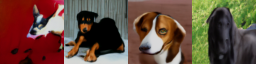

In [9]:
show_images(samples_CF)

In [10]:
# Create CLIP model.
clip_model = create_clip_model(device=device)
try:
    clip_model.image_encoder.load_state_dict(th.load('glide_model_cache/clip_image_enc.pt'))
    clip_model.text_encoder.load_state_dict(th.load('glide_model_cache/clip_text_enc.pt'))
except:
    clip_model.image_encoder.load_state_dict(load_checkpoint('clip/image-enc', device))
    clip_model.text_encoder.load_state_dict(load_checkpoint('clip/text-enc', device))


<All keys matched successfully>

In [11]:
########################################
# Sample from the base model with CLIP #
########################################

# Create the text tokens to feed to the model.
model_kwargs = get_model_kwargs(prompts, model, options, device)
cond_fn = clip_model.cond_fn(prompts, guidance_scale)

# Create a classifier-free guidance sampling function

model.del_cache()
samples_CLIP = diffusion.p_sample_loop(
    model,
    (batch_size, 3, options["image_size"], options["image_size"]),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=cond_fn,
)
model.del_cache()

print(samples_CLIP.shape)

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([4, 3, 64, 64])


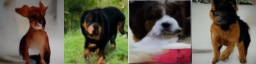

In [12]:
show_images(samples_CLIP)

In [13]:
# Create upsampler model.
options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
try:
    model_up.load_state_dict(th.load('glide_model_cache/upsample.pt'))
except:
    model_up.load_state_dict(load_checkpoint('upsample', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

total upsampler parameters 398361286


In [14]:
upsample_temp = 0.999

  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([4, 3, 256, 256])


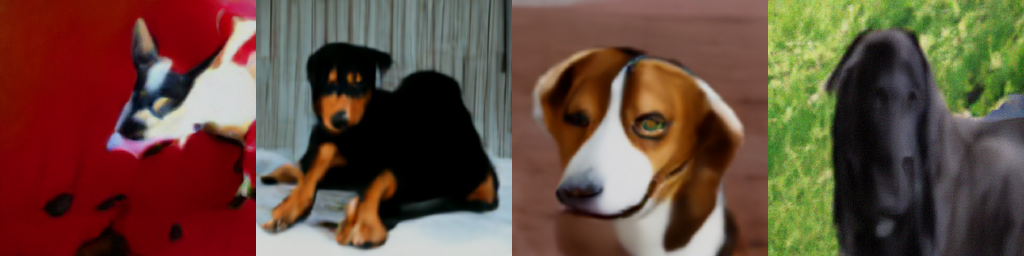

  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([4, 3, 256, 256])


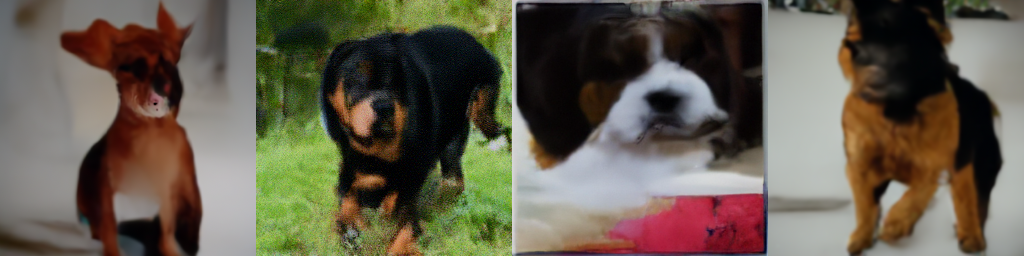

In [15]:
#################################
# Upsample the 64x64 CF Samples #
#################################

model_kwargs = get_model_kwargs_upsample(prompts, samples_CF, model, options, device)
up_samples_CF = returnUpSample(model_up, diffusion_up, batch_size, device, model_kwargs, options_up, upsample_temp=1.0, cond_fn=None, progress=True)

print(up_samples_CF.shape)
# Show the output
show_images(up_samples_CF)

##################################
# Upsample the 64x64 CLIP Samples#
##################################

model_kwargs = get_model_kwargs_upsample(prompts, samples_CLIP, model, options, device)
up_samples_CLIP = returnUpSample(model_up, diffusion_up, batch_size, device, model_kwargs, options_up, upsample_temp=1.0, cond_fn=None, progress=True)

print(up_samples_CLIP.shape)
# Show the output
show_images(up_samples_CLIP)


Here, we wanted to test how well the guidance scale feature works with classifier free. We will take one prompt and sample it at various different guidance scales.

In [16]:
prompts = ['Chihuahua', 'Rottweiler', 'French_bulldog', 'German_shepherd']
batch_size = len(prompts)
guidance_scales = [0, 1, 2, 3, 6, 12]
upSample = False #Change to True to enable upsampling

Generating with guidance scale:  0


  0%|          | 0/100 [00:00<?, ?it/s]

Original Sample: 


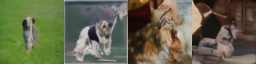

Generating with guidance scale:  1


  0%|          | 0/100 [00:00<?, ?it/s]

Original Sample: 


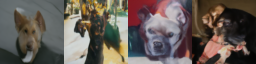

Generating with guidance scale:  2


  0%|          | 0/100 [00:00<?, ?it/s]

Original Sample: 


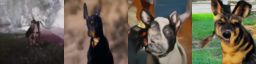

Generating with guidance scale:  3


  0%|          | 0/100 [00:00<?, ?it/s]

Original Sample: 


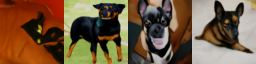

Generating with guidance scale:  6


  0%|          | 0/100 [00:00<?, ?it/s]

Original Sample: 


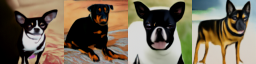

Generating with guidance scale:  12


  0%|          | 0/100 [00:00<?, ?it/s]

Original Sample: 


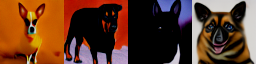

In [17]:
for guidance_scale in guidance_scales:
    print("Generating with guidance scale: ", guidance_scale)
    
    def model_fn(x_t, ts, guidance_scale=guidance_scale, **kwargs):
        half = x_t[: len(x_t) // 2]
        combined = th.cat([half, half], dim=0)
        model_out = model(combined, ts, **kwargs)
        eps, rest = model_out[:, :3], model_out[:, 3:]
        cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
        half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
        eps = th.cat([half_eps, half_eps], dim=0)
        return th.cat([eps, rest], dim=1)

    model_kwargs = get_model_kwargs_classifier_free(prompts, model, options, device)
    samples_CF = returnSample_CF(model, model_fn, model_kwargs, device, batch_size, options, diffusion)[:batch_size]
    print("Original Sample: ")
    show_images(samples_CF)

    # model_kwargs = get_model_kwargs_upsample(prompts, samples_CF, model, options, device)
    # up_samples_CF = returnUpSample(model_up, diffusion_up, batch_size, device, model_kwargs, options_up, upsample_temp=1.0, cond_fn=None, progress=True)
    # print("Upsampled Sample: ")
    # show_images(up_samples_CF)